# LINMA2171 - Numerical Analysis: Approximation, Interpolation, Integration
## Homework 3

---

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Simulation

In [2]:
def g(x, beta):
    return beta * x[0]**2 + x[1]**2 - 1

def jacobian_g(x, beta):
    B = np.array([[beta, 0], [0, 1]])
    return 2 * x.T @ B

# System of the form :
# C(x, lambda, t) x' = D

def C(x_t, lam_t, beta):
    C = np.zeros((3, 3), dtype=complex)
    C[0, 0] = 2  * lam_t * beta - 1
    C[0, 1] = 0
    C[0, 2] = 2 * beta * x_t[0]
    C[1, 0] = 0
    C[1, 1] = 2 * lam_t - 1
    C[1, 2] = 2 * x_t[1]
    C[2, 0] = 2 * beta * x_t[0]
    C[2, 1] = 2 * x_t[1]
    C[2, 2] = 0
    return C

def D(lam_0):
    D = np.zeros((3, 1), dtype=complex)
    D[0, 0] = -1
    D[1, 0] = -2 * lam_0
    D[2, 0] = 0
    return D

def simulate(beta, lam0, t0, tf, dt):
    N = int((tf - t0) / dt) + 1
    t = np.linspace(t0, tf, N)
    x = np.zeros((2, N), dtype=complex)
    lam = np.zeros(N, dtype=complex)

    # Initial conditions
    x[:, 0] = np.array([0.0, 1.0])
    lam[0] = lam0

    for i in range(1, N):
        C_mat = C(x[:, i-1], lam[i-1], beta)
        D_vec = D(lam0)
        sol = np.linalg.solve(C_mat, D_vec)
        x[0, i] = x[0, i-1] + sol[0, 0] * dt
        x[1, i] = x[1, i-1] + sol[1, 0] * dt
        lam[i] = lam[i-1] + sol[2, 0] * dt

    return t, x, lam


 

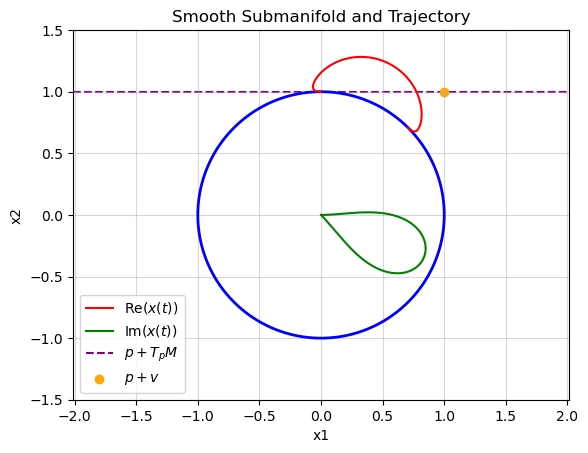

Final point: [0.70718432+5.70678126e-05j 0.70703029-6.91993743e-05j]


In [3]:
RANGE_X = 1.5
RANGE_Y = 1.5


def plot_q1(x):
    domain = np.meshgrid(np.linspace(-RANGE_X, RANGE_X, 1000),
                         np.linspace(-RANGE_Y, RANGE_Y, 1000))
    X, Y = domain

    # Plot smooth submanifold
    Z = g(np.array([X, Y]), beta=1.0)
    plt.contour(X, Y, Z, levels=[0], colors='blue', linewidths=2)
   


    # Plot real and imaginary parts of the trajectory
    plt.plot(x[0, :].real, x[1, :].real, 'r-', label=r'$\mathrm{Re}(x(t))$')
    plt.plot(x[0, :].imag, x[1, :].imag, 'g-', label=r'$\mathrm{Im}(x(t))$')


    # Plot p + TpM
    ## Vectors with second component 0 are in TpM at p = (0, 1)
    ## Thus, p + TpM is the horizontal line y = 1
    plt.axhline(y=1, color='purple', linestyle='--', label=r'$p + T_pM$', zorder=-1)  


    # Plot p + v
    v = np.array([1, 0.0])
    p = np.array([0, 1])
    plt.scatter(p[0] + v[0], p[1] + v[1], color='orange', label=r'$p + v$')  

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Smooth Submanifold and Trajectory')
    plt.axis('equal')
    plt.grid(alpha=0.5)    
    plt.legend()
    plt.savefig('figures/q1_plot.svg', format='svg')
    plt.show()

t, x, lam = simulate(beta=1.0, lam0=1 + 1j, t0=0.0, tf=1.0, dt=0.0001)
plot_q1(x)
print("Final point:", x[:, -1])


### 2. Norm of H as a function of $t$ for different $\Delta t$

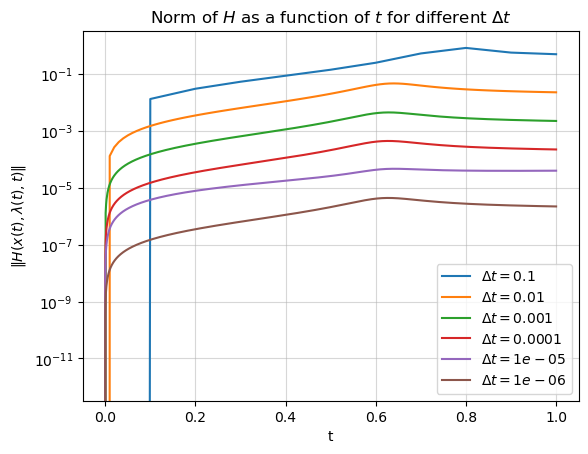

In [4]:
lam0 = 1 + 1j
p = np.array([0.0, 1.0])
v = np.array([1.0, 0.0])

def H(x, lam, t, beta):
    H1 = jacobian_g(x, beta).T * lam - (1-t) * jacobian_g(p, beta).T * lam0 + p + t * v - x
    H2 = g(x, beta)
    return np.array([H1[0], H1[1], H2])

dts = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
t = {}
H_norms = {}

for dt in dts:
    t[dt], x, lam = simulate(beta=1.0, lam0=lam0, t0=0.0, tf=1.0, dt=dt)
    H_norms[dt] = np.zeros_like(t[dt], dtype=float)
    for i in range(t[dt].shape[0]):
        H_val = H(x[:, i], lam[i], t[dt][i], beta=1.0)
        H_norms[dt][i] = np.linalg.norm(H_val)

plt.figure()
for dt in dts:
    plt.plot(t[dt], H_norms[dt], label=r'$\Delta t = {}$'.format(dt))
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\|H(x(t), \lambda(t), t)\|$')
plt.title(r'Norm of $H$ as a function of $t$ for different $\Delta t$')
plt.legend()
plt.grid(alpha=0.5)
plt.savefig('figures/q2_H_norms.svg', format='svg')
plt.show()


### 2.b) Adding Newton correction steps

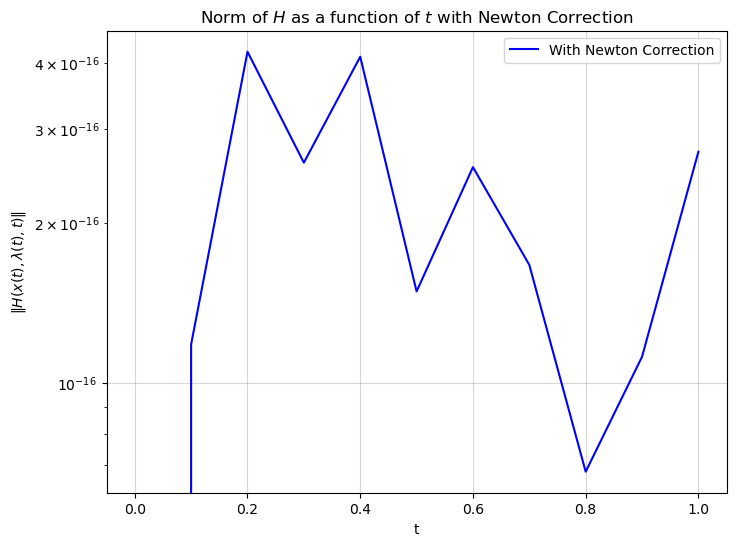

In [46]:
def simulate_newton(beta, lam0, t0, tf, dt):
    N = int((tf - t0) / dt) + 1
    t = np.linspace(t0, tf, N)
    x = np.zeros((2, N), dtype=complex)
    lam = np.zeros(N, dtype=complex)

    # Initial conditions
    x[:, 0] = np.array([0.0, 1.0])
    lam[0] = lam0

    for i in range(1, N):
        C_mat = C(x[:, i-1], lam[i-1], beta)
        D_vec = D(lam0)
        sol = np.linalg.solve(C_mat, D_vec)
        temp_x0_i = x[0, i-1] + sol[0, 0] * dt
        temp_x1_i = x[1, i-1] + sol[1, 0] * dt
        temp_lambda_i = lam[i-1] + sol[2, 0] * dt

        # Newton correction step
        t_i = t[i]
        delta = np.ones(3)  # Initialize delta
        tol = 1e-10

        while np.linalg.norm(delta) > tol:  # 5 Newton iterations
            H_val = H(np.array([temp_x0_i, temp_x1_i]), temp_lambda_i, t_i, beta)
            J = C(np.array([temp_x0_i, temp_x1_i]), temp_lambda_i, beta)

            delta = np.linalg.solve(J, -H_val)
            temp_x0_i += delta[0]
            temp_x1_i += delta[1]
            temp_lambda_i += delta[2]

        x[0, i] = temp_x0_i
        x[1, i] = temp_x1_i
        lam[i] = temp_lambda_i

    return t, x, lam


t_newton, x_newton, lam_newton = simulate_newton(beta=1.0, lam0=lam0, t0=0.0, tf=1.0, dt=0.1)
H_norms_newton = np.zeros_like(t_newton, dtype=float)
for i in range(t_newton.shape[0]):
    H_val = H(x_newton[:, i], lam_newton[i], t_newton[i], beta=1.0)
    H_norms_newton[i] = np.linalg.norm(H_val)
plt.figure(figsize=(8, 6))
plt.plot(t_newton, H_norms_newton, 'b-', label='With Newton Correction')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\|H(x(t), \lambda(t), t)\|$')
plt.title(r'Norm of $H$ as a function of $t$ with Newton Correction')
plt.legend()
plt.grid(alpha=0.5)
plt.savefig('figures/q2_H_norms_newton.svg', format='svg')
plt.show()

### 3. Trajectories of $\lambda(t)$ in the complex plane for different $\beta$ depending on the initial value $\lambda_0$

Beta: 0.5, Lambda0: (1-1j), Final H norm: 1.742490e-30
Beta: 0.5, Lambda0: (-1+1j), Final H norm: 8.100825e-31
Beta: 0.5, Lambda0: (-1-1j), Final H norm: 5.489199e-28
Beta: 0.5, Lambda0: (1+1j), Final H norm: 1.184417e-32
Beta: 0.5, Lambda0: (2+0j), Final H norm: 5.105232e-33


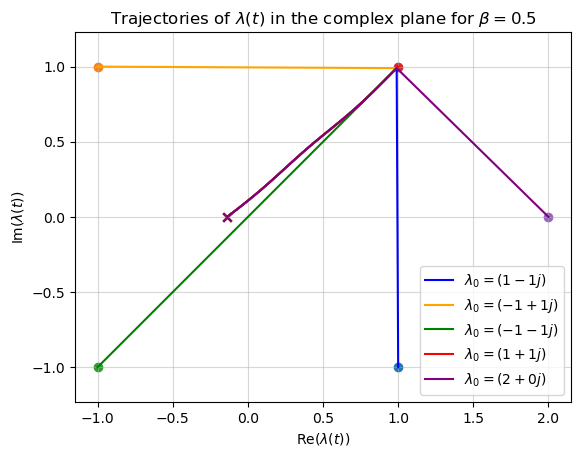

Beta: 1.0, Lambda0: (1-1j), Final H norm: 1.110223e-16
Beta: 1.0, Lambda0: (-1+1j), Final H norm: 2.220446e-16
Beta: 1.0, Lambda0: (-1-1j), Final H norm: 2.719480e-16
Beta: 1.0, Lambda0: (1+1j), Final H norm: 2.719480e-16
Beta: 1.0, Lambda0: (2+0j), Final H norm: 2.719480e-16


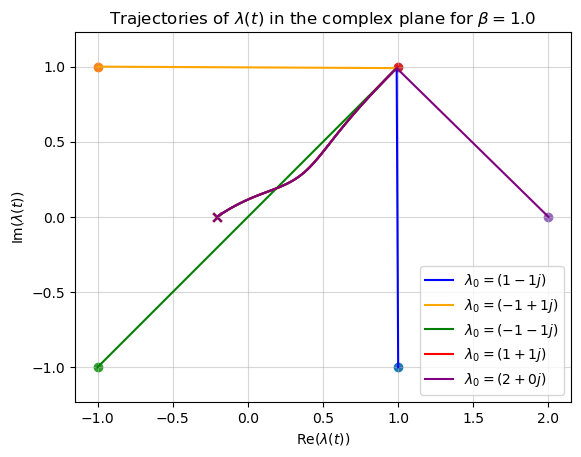

Beta: 5.0, Lambda0: (1-1j), Final H norm: 6.521084e-16
Beta: 5.0, Lambda0: (-1+1j), Final H norm: 3.764949e-16
Beta: 5.0, Lambda0: (-1-1j), Final H norm: 2.719480e-16
Beta: 5.0, Lambda0: (1+1j), Final H norm: 7.850462e-17
Beta: 5.0, Lambda0: (2+0j), Final H norm: 2.830524e-16


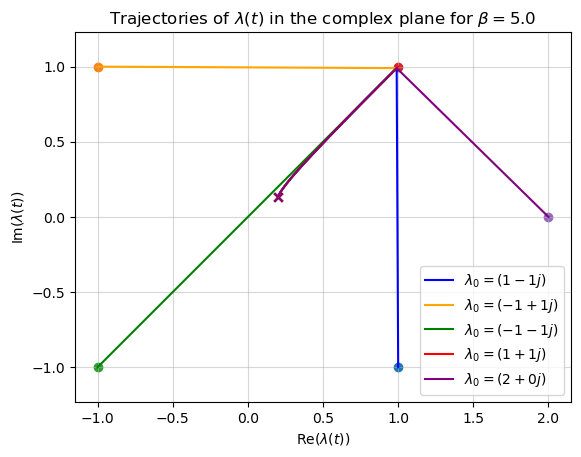

In [42]:
import itertools
from matplotlib import colors

    
def plot_lambda_trajectories(beta, lam0_values, t0, tf, dt):
    plt.figure()
    cmap = colors.ListedColormap(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    for i, lam0 in enumerate(lam0_values):
        t, x, lam = simulate_newton(beta, lam0, t0, tf, dt)
        plt.scatter(lam0.real, lam0.imag, marker='o')
        plt.scatter(lam[-1].real, lam[-1].imag, marker='x', color=cmap(i))
        plt.plot(lam.real, lam.imag, label=r'$\lambda_0 = {}$'.format(lam0), color=cmap(i))

        # Print error at final time
        H_final = H(x[:, -1], lam[-1], t[-1], beta)
        error = np.linalg.norm(H_final)
        print(f'Beta: {beta}, Lambda0: {lam0}, Final H norm: {error:e}')

    plt.xlabel(r'Re$(\lambda(t))$')
    plt.ylabel(r'Im$(\lambda(t))$')
    plt.title(r'Trajectories of $\lambda(t)$ in the complex plane for $\beta = {}$'.format(beta))
    plt.axis('equal')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.savefig('figures/q3_lambda_trajectories_beta_{}.svg'.format(beta), format='svg')
    plt.show()

betas = [0.5, 1.0, 5.0]
lambda0_values = [ 1 - 1j, -1 + 1j, -1 - 1j, 1 + 1j, 2 + 0j]
t0, tf = 0.0, 1.0
dt = 0.01 
for beta in betas:
    plot_lambda_trajectories(beta, lambda0_values, t0, tf, dt)

